## Creating the GAN Model and training on the real and synthetic pizza data

0. Importing the required libraries

In [ ]:
#Imports
from __future__ import print_function
import argparse
from tqdm import tqdm
from datetime import date
import os
import os.path
import pickle
import torchvision
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML



1. Creating the classes of Generator and Discriminator used for our GANs

1.1 The residual block is defined

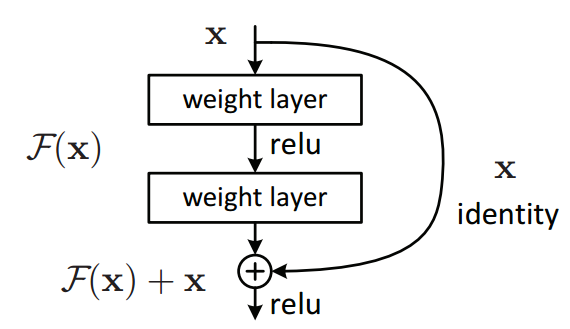

In [ ]:
#Defining the ResidualBlock to be used in Generator from J. Johnson et. al.
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        
        self.res = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.res(x)

1.2 The discriminator architecture is defined as mentioned in the instructions

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()        
        self.disc_model = nn.Sequential(
            #C64
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            #C128
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            #C256
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            #C512
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            #1D output
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.disc_model(x)        
        return x

1.3 The generator architecture is defined as mentioned in the instructions (with certain changes as mentioned in the report)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()        
        self.gen_model = nn.Sequential(
            
            #c7s1-64
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7,stride = 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            
            #d128
            nn.Conv2d(64, 128, 3, stride=2, padding=1,bias=False),
            nn.InstanceNorm2d(128,affine=True),
            nn.ReLU(inplace=True),

            #d256
            nn.Conv2d(128, 256, 3, stride=2, padding=1,bias=False),
            nn.InstanceNorm2d(256,affine=True),
            nn.ReLU(inplace=True),
            
            # 9x R256
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            #u128
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            #u64
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            #c7s1-3
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7, stride=1,padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen_model(x)


2. Setting up the hyperparameters

In [ ]:
manualSeed = 42
BATCH_SIZE = 8 #64 for a high memory GPU, for ilab set to 8
IMG_SIZE = 256
NGPU = 4 #set to 4 on ilab, 1 on colab
NUM_EPOCHS = 275
num_workers = 1
lr = 2e-4
beta1 = 0.5
is_resume = True
shuffle = True
starting_epoch = 258
resume_path_gen = "checkpoint/gen_epoch_"+str(starting_epoch+1)+".pth"
resume_path_disc = "checkpoint/disc_epoch_"+str(starting_epoch+1)+".pth"
random.seed(manualSeed)
torch.manual_seed(manualSeed)

3. Getting the data into format we want 256x256x3 by transformation

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
    )

In [ ]:
training_data = dset.ImageFolder(
    root="realpizza", # root = 'realpizza' for training on real pizza   and 'syntheticpizza' otherwise
    transform=transform
)
dataloader = torch.utils.data.DataLoader(training_data,batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=num_workers)

4. Setting up model

4.1 Initializing weights with mean 0 and standard deviation 0.02

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

4.2 Load model from saved checkpoint or initialize weights

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and NGPU > 0) else "cpu")
#device = torch.device("cpu")
gen = Generator().to(device)
if (device.type == 'cuda') and (NGPU > 1):
    gen = nn.DataParallel(gen, list(range(NGPU)))
disc = Discriminator().to(device)
if (device.type == 'cuda') and (NGPU > 1):
    disc = nn.DataParallel(disc, list(range(NGPU)))

if is_resume:
    gen.load_state_dict(torch.load(resume_path_gen))
    disc.load_state_dict(torch.load(resume_path_disc))
    print("Training to resume from epoch: {}".format(starting_epoch))
else:   
    gen.apply(weights_init)
    disc.apply(weights_init)

4.3 Setting up the model for running with loss functions and optimizer

In [ ]:
criterion = nn.MSELoss()
real_label = 1
fake_label = 0
optimizer_disc = optim.Adam(disc.parameters(),lr=lr,betas=(beta1,0.999))
optimizer_gen = optim.Adam(gen.parameters(),lr=lr,betas=(beta1,0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0
fixed_noise = torch.randn(BATCH_SIZE, 3, 256, 256, device=device)

with torch.no_grad():
    fake = gen(fixed_noise).detach().cpu()


In [ ]:
#Saving the initial image output of generator
img_grid = vutils.make_grid(fake, nrow= 4, padding=2, normalize=True)
img_list.append(img_grid)
torchvision.utils.save_image(img_grid,"results/init_img_epoch_"+str(starting_epoch)+".png")

5. Running the model

In [ ]:
for epoch in range(starting_epoch+1,NUM_EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):       
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        real_label = torch.full((b_size, 1,30,30), 1, device=device, dtype=torch.float32)
        fake_label = torch.full((b_size, 1,30,30), 0, device=device, dtype=torch.float32)
        noise = torch.randn(b_size, 3, 256, 256, device=device)       
        # Train the discriminator
        optimizer_disc.zero_grad()
        real_d_output = disc(real_img)
        loss_d_real = criterion(real_d_output,real_label)
        fake_d_output = disc(gen(noise).detach())
        loss_d_fake = criterion(fake_d_output,fake_label)
        loss_d = (loss_d_real+loss_d_fake)/2
        loss_d.backward()
        optimizer_disc.step()
        # Train the generator
        optimizer_gen.zero_grad()
        fake_img = gen(noise)
        fake_g_output = disc(fake_img)
        loss_g = criterion(fake_g_output,real_label)
        loss_g.backward()
        optimizer_gen.step()
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
              % (epoch, NUM_EPOCHS, i, len(dataloader),
                  loss_d.item(), loss_g.item()))
        # Save Losses for evaluation
        G_losses.append(loss_g.item())
        D_losses.append(loss_d.item())
        iters += 1
    with torch.no_grad():
        fake = gen(fixed_noise).detach().cpu()
    img_grid = vutils.make_grid(fake, nrow = 4, padding=2, normalize=True)
    img_list.append(img_grid)       
    torchvision.utils.save_image(img_grid,"results/img_epoch_"+str(epoch+1)+".png")
    torch.save(gen.state_dict(), "checkpoint/gen_epoch_"+str(epoch+1)+".pth")
    torch.save(disc.state_dict(), "checkpoint/disc_epoch_"+str(epoch+1)+".pth")